# 🐍 Machine Learning Project Script

In [1]:
import pandas as pd
import ast
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# 1. Upload data

In [2]:
df_train_raw = pd.read_csv("train.csv", sep=',')
df_train_raw["edgelist"].head(1)
df_train_raw["edgelist"] = df_train_raw["edgelist"].apply(ast.literal_eval)

df_test_raw = pd.read_csv("test.csv", sep=',')
df_test_raw["edgelist"].head(1)
df_test_raw["edgelist"] = df_test_raw["edgelist"].apply(ast.literal_eval)

# 2. Pre-Processing


In [3]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from itertools import combinations
from community import community_louvain  # pip install python-louvain

def normalize_group(df_group):
    numeric_cols = [
        'degree', 'closeness', 'betweenness', 'pagerank',
        'eigenvector', 'katz', 'load',
        'eccentricity', 'avg_neighbor_degree', 'community' 
        #'shortest_path_length', 'is_leaf', 'neighbor_connectivity'
    ]
    scaler = MinMaxScaler()
    df_group[numeric_cols] = scaler.fit_transform(df_group[numeric_cols])
    return df_group

def pre_processing(data):
    training_data = []

    for idx, row in data.iterrows():
        edgelist = row["edgelist"]
        
        # Create undirected graph
        T = nx.Graph()
        T.add_edges_from(edgelist)

        if not nx.is_connected(T):
            continue
        
        root_node = row.get("root", None)
        
        # Compute centralities
        closeness = nx.closeness_centrality(T)
        betweenness = nx.betweenness_centrality(T)
        pagerank = nx.pagerank(T, max_iter=1000)
        
        # Additional centrality measures with fallbacks
        try:
            eigenvector = nx.eigenvector_centrality(T, max_iter=10000, tol=1e-06)
        except nx.PowerIterationFailedConvergence:
            eigenvector = {n: 0.0 for n in T.nodes}
            
        try:
            katz = nx.katz_centrality(T, alpha=0.1)
        except nx.NetworkXException:
            katz = {n: 0.0 for n in T.nodes}
            
        try:
            load = nx.load_centrality(T)
        except:
            load = {n: 0.0 for n in T.nodes}

        # Structural properties
        degree = dict(T.degree())
        eccentricity = nx.eccentricity(T)
        avg_neighbor_degree = nx.average_neighbor_degree(T)
        
        # Community detection
        partition = community_louvain.best_partition(T)
        
        for v in T.nodes:
            features = {
                "sentence": row["sentence"],
                "language": row["language"],
                "n": row["n"],
                "node": v,

                # Centrality measures
                "degree": degree[v],
                "closeness": closeness[v],
                "betweenness": betweenness[v],
                "pagerank": pagerank[v],
                "eigenvector": eigenvector[v],
                "katz": katz[v],
                "load": load[v],

                # Structural properties
                "eccentricity": eccentricity[v],
                "avg_neighbor_degree": avg_neighbor_degree[v],

                # Community information
                "community": partition[v],

                "is_leaf": 1 if T.degree(v) == 1 else 0,
            }

            if "id" in row:
                features["id"] = row["id"]

            if root_node is not None:
                features["is_root"] = 1 if v == root_node else 0

            training_data.append(features)

    training_data = pd.DataFrame(training_data)
    
    # Normalize features by group
    df_normalized = training_data.groupby(["sentence", "language"], group_keys=True).apply(
        normalize_group, include_groups=False
    )
    df_normalized.reset_index(inplace=True)
    df_normalized.drop(columns=["level_2"], inplace=True)

    return df_normalized

In [4]:
df_train = pre_processing(df_train_raw)
df_train

,sentence,language,n,node,degree,closeness,betweenness,pagerank,eigenvector,katz,load,eccentricity,avg_neighbor_degree,community,is_leaf,is_root
0,2,Arabic,21,10,1.00,0.730183,0.724771,0.932971,0.990346,0.996388,0.724771,0.571429,0.555556,0.000000,0,1
1,2,Arabic,21,8,1.00,0.908084,0.990826,0.891309,1.000000,1.000000,0.990826,0.428571,0.555556,0.250000,0,0
2,2,Arabic,21,5,0.50,0.598665,0.174312,0.518343,0.547862,0.477072,0.174312,0.571429,0.333333,0.250000,0,0
3,2,Arabic,21,13,0.00,0.356589,0.000000,0.042182,0.236520,0.004953,0.000000,0.714286,0.333333,0.250000,1,0
4,2,Arabic,21,6,0.50,0.976170,0.908257,0.415764,0.703950,0.567473,0.908257,0.285714,1.000000,0.250000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197474,995,Turkish,16,14,0.25,0.356543,0.200000,0.277926,0.417002,0.302740,0.200000,0.666667,0.411765,0.666667,0,0
197475,995,Turkish,16,10,0.00,0.061625,0.000000,0.029047,0.103774,0.004653,0.000000,1.000000,0.117647,0.666667,1,0
197476,995,Turkish,16,2,0.50,1.000000,0.885714,0.467346,0.842910,0.614483,0.885714,0.000000,0.509804,0.000000,0,0
197477,995,Turkish,16,1,0.00,0.304498,0.000000,0.007093,0.335177,0.074379,0.000000,0.666667,1.000000,0.666667,1,0


Feature selection

## Random Forest modified


# 3. Models

**K-Fold Cross Validation**

In [20]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from collections import defaultdict

class GroupAwareRandomForest:
    """
    A custom Random Forest that performs group-aware prediction without restricting
    to only one positive prediction per group. All instances in a group that meet
    the prediction threshold will be predicted as positive.
    """

    def __init__(self, n_estimators=50, max_depth=None, min_samples_split=2, 
                 class_weight=None, random_state=42, threshold=0.5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_weight = class_weight
        self.random_state = random_state
        self.threshold = threshold  # Prediction threshold for positive class
        self.trees = []

    def fit(self, X, y, group_ids):
        np.random.seed(self.random_state)
        self.trees = []

        unique_groups = np.unique(group_ids)
        group_to_indices = defaultdict(list)
        for idx, group in enumerate(group_ids):
            group_to_indices[group].append(idx)

        for _ in range(self.n_estimators):
            sampled_groups = np.random.choice(unique_groups, size=int(0.8 * len(unique_groups)), replace=True)
            sampled_indices = []
            for group in sampled_groups:
                sampled_indices.extend(group_to_indices[group])
            sampled_indices = np.array(sampled_indices)

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                class_weight=self.class_weight,
                random_state=self.random_state
            )
            tree.fit(X.iloc[sampled_indices], y.iloc[sampled_indices])
            self.trees.append(tree)

    def predict_proba(self, X):
        """
        Return the mean predicted probability across all trees.
        For binary classification, returns probabilities for the positive class.
        """
        # For binary classification, we take the second column (index 1) which is for class=1
        probas = [tree.predict_proba(X)[:, 1] for tree in self.trees]
        return np.mean(probas, axis=0)

    def predict(self, X, group_ids):
        """
        Predicts labels for X group-wise, where all instances in a group that meet
        the probability threshold will be predicted as positive.
        """
        probas = self.predict_proba(X)

        group_to_indices = defaultdict(list)
        for i, g in enumerate(group_ids):
            group_to_indices[g].append(i)

        final_preds = np.zeros(len(X), dtype=int)
        for g, idxs in group_to_indices.items():
            # Predict positive for all instances in group that meet threshold
            for idx in idxs:
                if probas[idx] >= self.threshold:
                    final_preds[idx] = 1
        return final_preds

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
from collections import defaultdict

def enhanced_training(df, features, n_folds=5):
    df['group_id'] = df["sentence"].astype(str) + '_' + df["language"]
    X = df[features]
    y = df['is_root']
    groups = df["group_id"]

    results = {}

    model = GroupAwareRandomForest(
        n_estimators=50, 
        max_depth=20, 
        min_samples_split=10, 
        class_weight="balanced", 
        random_state=42
    )

    metrics = {'precision': [], 'recall': [], 'f1': [], 'support': []}

    cv = StratifiedGroupKFold(n_splits=n_folds)

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=groups)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        group_train = groups.iloc[train_idx]
        group_val = groups.iloc[val_idx]

        model.fit(X_train, y_train, group_train)

        # Predecir y evaluar
        y_pred = model.predict(X_val, group_val)
        report = classification_report(y_val, y_pred, output_dict=True)
        metrics['precision'].append(report['weighted avg']['precision'])
        metrics['recall'].append(report['weighted avg']['recall'])
        metrics['f1'].append(report['weighted avg']['f1-score'])
        metrics['support'].append(report['weighted avg']['support'])

    # Guardar métricas promedio
    results[model] = {
        'precision': np.mean(metrics['precision']),
        'recall': np.mean(metrics['recall']),
        'f1': np.mean(metrics['f1']),
        'support': np.mean(metrics['support'])
    }

    # Final model and confusion matrix
    model.fit(X, y, groups)
    y_pred = model.predict(X, group_ids=groups)

    print(f"\n=== Final Training Set Evaluation ===")
    train_report = classification_report(y, y_pred)
    print(train_report)

    y_pred
    cm = confusion_matrix(y, y_pred)

    plt.subplot(2, 2, 4)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return model



=== Final Training Set Evaluation ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    186979
           1       0.50      0.92      0.64     10500

    accuracy                           0.95    197479
   macro avg       0.75      0.93      0.81    197479
weighted avg       0.97      0.95      0.95    197479



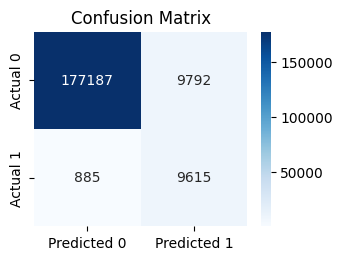

In [22]:
# === Run pipeline ===

features = [col for col in df_train.columns if col not in ['id', 'sentence', 'language', 'is_root', 'group_id']]

model= enhanced_training(df_train, features)

#model, best_threshold, predict_fn = enhanced_training_with_threshold_analysis_XGB(df_train, features)



In [ ]:
# Preprocesamiento del test
df_test_processed = pre_processing(df_test_raw.copy())
df_test_processed['group_id'] = df_test_processed["sentence"].astype(str) + '_' + df_test_processed["language"]
X_test = df_test_processed[features]
groups = df_test_processed["group_id"]

# Usamos el método predict de tu clase personalizada (no hay predict_proba)
df_test_processed['pred'] = model.predict(X_test, groups)

# Simulamos una probabilidad 1 para predicción positiva (esto es un parche si necesitas un score)
df_test_processed['pred_proba'] = df_test_processed['pred'].astype(float)


# Selección de nodo raíz por grupo (máxima probabilidad o 1 en el caso del modelo personalizado)
predicted_roots = df_test_processed.loc[
    df_test_processed.groupby('id')['pred_proba'].idxmax()
]

# Formateo final
output_df = predicted_roots[['id', 'node']].rename(columns={'node': 'root'})
output_df = output_df.sort_values('id').reset_index(drop=True)
output_df.to_csv('predicted_roots.csv', index=False)
